## Data Preprocessing and Model Training

In [1]:
# General Libraries:
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Deep Learning libraries:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications import Xception

### Data Loading and Cleaning

In [2]:
def load_data(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, label)):
            img_path = os.path.join(directory, label, image)

            # Read and resize the image using Pillow
            img = Image.open(img_path)
            img_array = np.array(img)

            # Append the image array and the label to the lists
            images.append(img_array)
            labels.append(label)

    # Shuffle the arrays using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=42)

    return images, labels

In [3]:
train_dir = r'C:\Users\fante\Desktop\Brain-Tumor-Classification\00 - Dataset\Training'
test_dir = r'C:\Users\fante\Desktop\Brain-Tumor-Classification\00 - Dataset\Testing'

# Load training data
train_images, train_labels = load_data(train_dir)

# Load testing data
test_images, test_labels = load_data(test_dir)

In [4]:
# Check data structure

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print("Number of Images in Train Set:", num_train_images)
print("Number of Labels in Train Set:", num_train_labels)
print("Number of Images in Test Set:", num_test_images)
print("Number of Labels in Test Set:", num_test_labels)

Number of Images in Train Set: 5712
Number of Labels in Train Set: 5712
Number of Images in Test Set: 1311
Number of Labels in Test Set: 1311


In [5]:
def remove_duplicates(images, labels):
    unique_pairs = set()
    unique_images = []
    unique_labels = []
    num_removed = 0

    for img, label in zip(images, labels):
        img_str = img.tobytes()
        pair = (img_str, label)

        # Check if the pair is unique
        if pair not in unique_pairs:
            unique_pairs.add(pair)
            unique_images.append(img)
            unique_labels.append(label)
        else:
            num_removed += 1

    print(f"Removed {num_removed} duplicate images.")
    
    return shuffle(unique_images, unique_labels, random_state=99)

In [6]:
# Remove duplicates from training data
train_images, train_labels = remove_duplicates(train_images, train_labels)

# Remove duplicates from testing data
test_images, test_labels = remove_duplicates(test_images, test_labels)

Removed 207 duplicate images.
Removed 30 duplicate images.


In [7]:
def print_class_distribution(labels, dataset_name):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    
    print(f"\nClass Distribution in {dataset_name} Dataset:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} images")
    
    total_images = len(labels)
    print(f"Total number of images in {dataset_name} Dataset: {total_images}")

# Print training data class distribution
print_class_distribution(train_labels, 'Training')

# Print testing data class distribution
print_class_distribution(test_labels, 'Testing')



Class Distribution in Training Dataset:
Class glioma: 1321 images
Class meningioma: 1333 images
Class notumor: 1406 images
Class pituitary: 1445 images
Total number of images in Training Dataset: 5505

Class Distribution in Testing Dataset:
Class glioma: 299 images
Class meningioma: 301 images
Class notumor: 381 images
Class pituitary: 300 images
Total number of images in Testing Dataset: 1281


### Data Preprocessing

In [8]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)

In [9]:
def preprocess_images(images, desired_size, normalize=True):
    preprocessed_images = []

    for img_array in images:
        # Convert numpy array to Pillow Image
        img = Image.fromarray(img_array)
        
        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)

        # Convert the image back to a numpy array
        img_array = np.array(img)

        # Normalize pixel values to the range [0, 1]
        if normalize:
            img_array = img_array / 255.0

        preprocessed_images.append(img_array)

    return preprocessed_images

In [10]:
width = 224
height = 244

train_images_processed = preprocess_images(train_images, desired_size=(width,height))
val_images_processed = preprocess_images(val_images, desired_size=(width,height))
test_images_processed = preprocess_images(test_images, desired_size=(width,height))

train_images_processed = np.array(train_images_processed)
val_images_processed = np.array(val_images_processed)

In [11]:

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)

train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

### Data Augmentation

In [12]:
# Create an ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Preprocess and augment training data
train_generator = datagen.flow(np.array(train_images_processed), train_labels_one_hot, batch_size=32)
val_generator = val_datagen.flow(np.array(val_images_processed), val_labels_one_hot, batch_size=32)

### Model Architecture

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 244, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 28, 128)       0

In [14]:
# Specify the number of training steps per epoch and validation steps
train_steps_per_epoch = len(train_generator)
val_steps_per_epoch = len(val_generator)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch)

Epoch 1/15
138/138 [==============================] - 349s 3s/step - loss: 1.2588 - accuracy: 0.4591 - val_loss: 0.8769 - val_accuracy: 0.6549
Epoch 2/15
138/138 [==============================] - 331s 2s/step - loss: 0.9346 - accuracy: 0.6058 - val_loss: 0.6903 - val_accuracy: 0.7511
Epoch 3/15
138/138 [==============================] - 342s 2s/step - loss: 0.8213 - accuracy: 0.6649 - val_loss: 0.6143 - val_accuracy: 0.7729
Epoch 4/15
138/138 [==============================] - 344s 2s/step - loss: 0.7644 - accuracy: 0.6805 - val_loss: 0.6070 - val_accuracy: 0.7439
Epoch 5/15
138/138 [==============================] - 345s 2s/step - loss: 0.7206 - accuracy: 0.7150 - val_loss: 0.5425 - val_accuracy: 0.7675
Epoch 6/15
138/138 [==============================] - 343s 2s/step - loss: 0.6691 - accuracy: 0.7330 - val_loss: 0.5357 - val_accuracy: 0.7811
Epoch 7/15
138/138 [==============================] - 342s 2s/step - loss: 0.6313 - accuracy: 0.7480 - val_loss: 0.5534 - val_accuracy: 0.7875

In [15]:
val_metrics = model.evaluate(val_generator, steps=val_steps_per_epoch)
print("Validation Metrics:", val_metrics)

35/35 [==============================] - 30s 869ms/step - loss: 0.3937 - accuracy: 0.8592
Validation Metrics: [0.3937256932258606, 0.8592188954353333]


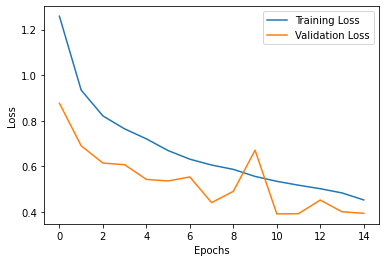

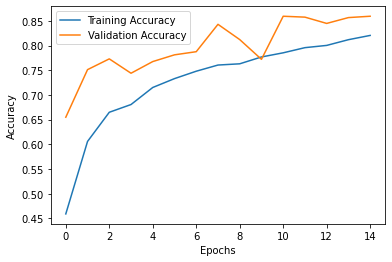

In [16]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
test_generator = val_datagen.flow(np.array(test_images_processed), test_labels_one_hot, batch_size=32)

test_steps_per_epoch = len(test_generator)
test_metrics = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", test_metrics)

41/41 [==============================] - 27s 654ms/step - loss: 0.5143 - accuracy: 0.8134
Test Metrics: [0.5142722725868225, 0.8134270310401917]


41/41 [==============================] - 28s 667ms/step


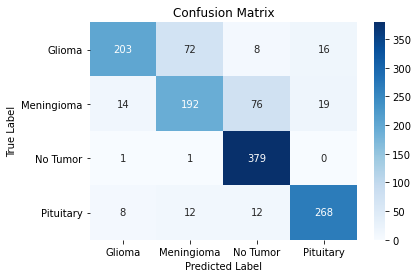

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       299
           1       0.69      0.64      0.66       301
           2       0.80      0.99      0.89       381
           3       0.88      0.89      0.89       300

    accuracy                           0.81      1281
   macro avg       0.82      0.80      0.80      1281
weighted avg       0.82      0.81      0.81      1281



In [18]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
predicted_labels = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))



### Model Optimization

- Added Dropout and BatchNormalization
- Added L2 regularization
- Used Early Stopping to ensure improvement

In [19]:
new_model = Sequential()

new_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 244, 3)))
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())

new_model.add(Conv2D(64, (3, 3), activation='relu'))
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())

new_model.add(Conv2D(128, (3, 3), activation='relu'))
new_model.add(MaxPooling2D((2, 2)))
new_model.add(BatchNormalization())

new_model.add(Flatten())
new_model.add(Dropout(0.3))

new_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
new_model.add(Dropout(0.2))

new_model.add(Dense(4, activation='softmax'))

new_model.compile(RMSprop(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 121, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 111, 121, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                      

In [20]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
new_history = new_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=11,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping]
)

Epoch 1/11
138/138 [==============================] - 420s 3s/step - loss: 3.7252 - accuracy: 0.5216 - val_loss: 4.0650 - val_accuracy: 0.4478
Epoch 2/11
138/138 [==============================] - 408s 3s/step - loss: 3.5004 - accuracy: 0.6138 - val_loss: 3.7780 - val_accuracy: 0.4714
Epoch 3/11
138/138 [==============================] - 399s 3s/step - loss: 3.3976 - accuracy: 0.6431 - val_loss: 3.6266 - val_accuracy: 0.4541
Epoch 4/11
138/138 [==============================] - 399s 3s/step - loss: 3.3472 - accuracy: 0.6460 - val_loss: 3.2498 - val_accuracy: 0.7012
Epoch 5/11
138/138 [==============================] - 400s 3s/step - loss: 3.2736 - accuracy: 0.6676 - val_loss: 3.1500 - val_accuracy: 0.7003
Epoch 6/11
138/138 [==============================] - 400s 3s/step - loss: 3.2072 - accuracy: 0.6848 - val_loss: 2.9887 - val_accuracy: 0.7893
Epoch 7/11
138/138 [==============================] - 397s 3s/step - loss: 3.1598 - accuracy: 0.6923 - val_loss: 2.9828 - val_accuracy: 0.7639

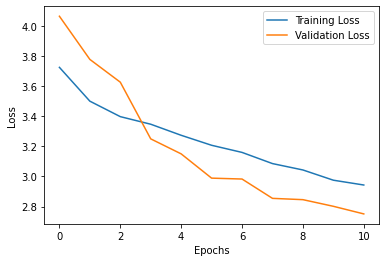

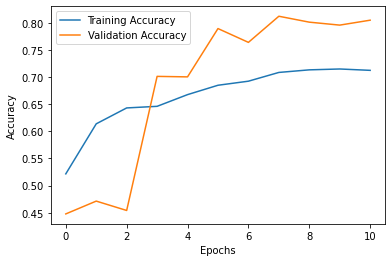

In [21]:
# Plot training history
plt.plot(new_history.history['loss'], label='Training Loss')
plt.plot(new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(new_history.history['accuracy'], label='Training Accuracy')
plt.plot(new_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
new_test_metrics = new_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", new_test_metrics)

41/41 [==============================] - 29s 704ms/step - loss: 2.9065 - accuracy: 0.7705
Test Metrics: [2.906477451324463, 0.7704917788505554]


41/41 [==============================] - 27s 640ms/step


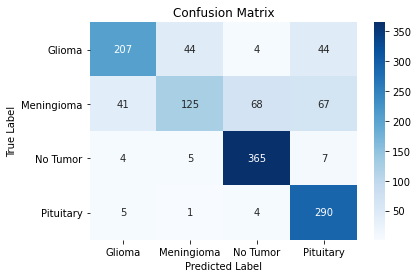

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       299
           1       0.71      0.42      0.53       301
           2       0.83      0.96      0.89       381
           3       0.71      0.97      0.82       300

    accuracy                           0.77      1281
   macro avg       0.76      0.76      0.74      1281
weighted avg       0.77      0.77      0.75      1281



In [23]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
new_predicted_labels = new_model.predict(test_generator, steps=test_steps_per_epoch)
new_predicted_labels = np.argmax(new_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, new_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, new_predicted_labels))

### HyperParameter Tunning

- Increased number of filters
- Increase dropout rates
- Used Adamax as optimizer
- Increased the number of epochs

In [24]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 244, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dropout(0.4))

model1.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dropout(0.3))

model1.add(Dense(4, activation='softmax'))

model1.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 242, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 121, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 111, 121, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 119, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 59, 128)       0         
 g2D)                                                            
                                                      

In [25]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the new model with early stopping
model1_history = model1.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/11
138/138 [==============================] - 954s 7s/step - loss: 6.9688 - accuracy: 0.4693 - val_loss: 6.2295 - val_accuracy: 0.2534
Epoch 2/11
138/138 [==============================] - 1008s 7s/step - loss: 5.1994 - accuracy: 0.5082 - val_loss: 5.8243 - val_accuracy: 0.2625
Epoch 3/11
138/138 [==============================] - 932s 7s/step - loss: 4.5163 - accuracy: 0.5402 - val_loss: 4.7781 - val_accuracy: 0.3115
Epoch 4/11
138/138 [==============================] - 937s 7s/step - loss: 3.8314 - accuracy: 0.5899 - val_loss: 4.1109 - val_accuracy: 0.4142
Epoch 5/11
138/138 [==============================] - 944s 7s/step - loss: 3.4342 - accuracy: 0.5774 - val_loss: 3.3814 - val_accuracy: 0.4977
Epoch 6/11
138/138 [==============================] - 1012s 7s/step - loss: 2.9463 - accuracy: 0.6156 - val_loss: 3.0163 - val_accuracy: 0.5522
Epoch 7/11
138/138 [==============================] - 983s 7s/step - loss: 2.6439 - accuracy: 0.6183 - val_loss: 2.5033 - val_accuracy: 0.62

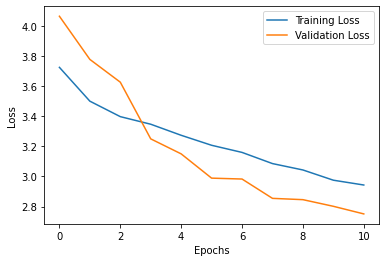

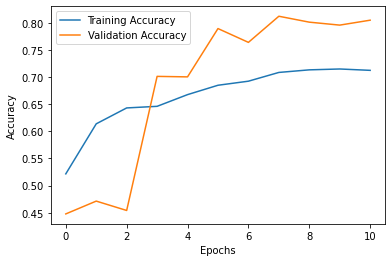

In [26]:
# Plot training history
plt.plot(new_history.history['loss'], label='Training Loss')
plt.plot(new_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(new_history.history['accuracy'], label='Training Accuracy')
plt.plot(new_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
new_test_metrics = new_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", new_test_metrics)

41/41 [==============================] - 28s 672ms/step - loss: 2.9065 - accuracy: 0.7705
Test Metrics: [2.906477451324463, 0.7704917788505554]


41/41 [==============================] - 26s 627ms/step


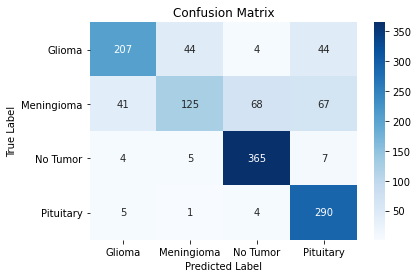

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.74       299
           1       0.71      0.42      0.53       301
           2       0.83      0.96      0.89       381
           3       0.71      0.97      0.82       300

    accuracy                           0.77      1281
   macro avg       0.76      0.76      0.74      1281
weighted avg       0.77      0.77      0.75      1281



In [28]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
new_predicted_labels = new_model.predict(test_generator, steps=test_steps_per_epoch)
new_predicted_labels = np.argmax(new_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, new_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, new_predicted_labels))

### Pre-trained Models

#### XCeption

In [29]:
base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(224, 244, 3))

for layer in base_model1.layers:
    layer.trainable = False

pre_trained1_model = Sequential()
pre_trained1_model.add(base_model1)
pre_trained1_model.add(layers.Flatten())
pre_trained1_model.add(layers.Dropout(0.5))
pre_trained1_model.add(layers.Dense(128, activation='relu'))
pre_trained1_model.add(layers.Dropout(0.5))
pre_trained1_model.add(layers.Dense(4, activation='softmax'))
pre_trained1_model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

pre_trained1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 8, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 114688)            0         
                                                                 
 dropout_4 (Dropout)         (None, 114688)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               14680192  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 35542188 (135.58 MB)
Trainable params: 1

In [30]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Fit the new model with early stopping
pretrained1_history = pre_trained1_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=11,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/11
138/138 [==============================] - 808s 6s/step - loss: 1.3722 - accuracy: 0.6735 - val_loss: 0.4351 - val_accuracy: 0.8365
Epoch 2/11
138/138 [==============================] - 794s 6s/step - loss: 0.5806 - accuracy: 0.7763 - val_loss: 0.3796 - val_accuracy: 0.8619
Epoch 3/11
138/138 [==============================] - 967s 7s/step - loss: 0.5203 - accuracy: 0.8043 - val_loss: 0.3511 - val_accuracy: 0.8629
Epoch 4/11
138/138 [==============================] - 952s 7s/step - loss: 0.4907 - accuracy: 0.8161 - val_loss: 0.3560 - val_accuracy: 0.8674
Epoch 5/11
138/138 [==============================] - 1011s 7s/step - loss: 0.4533 - accuracy: 0.8252 - val_loss: 0.3449 - val_accuracy: 0.8656
Epoch 6/11
138/138 [==============================] - 935s 7s/step - loss: 0.4399 - accuracy: 0.8292 - val_loss: 0.3259 - val_accuracy: 0.8747
Epoch 7/11
138/138 [==============================] - 863s 6s/step - loss: 0.4231 - accuracy: 0.8463 - val_loss: 0.3302 - val_accuracy: 0.878

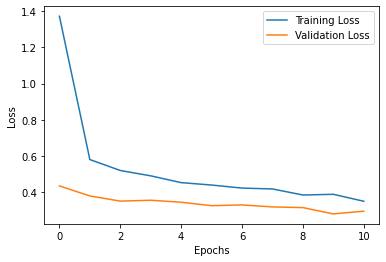

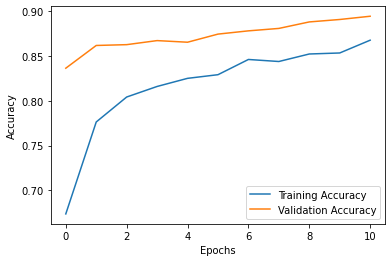

In [31]:
# Plot training history
plt.plot(pretrained1_history.history['loss'], label='Training Loss')
plt.plot(pretrained1_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(pretrained1_history.history['accuracy'], label='Training Accuracy')
plt.plot(pretrained1_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
pretrained1_test_metrics = pre_trained1_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", pretrained1_test_metrics)

41/41 [==============================] - 181s 4s/step - loss: 0.2962 - accuracy: 0.8798
Test Metrics: [0.29615721106529236, 0.8797814249992371]


41/41 [==============================] - 179s 4s/step


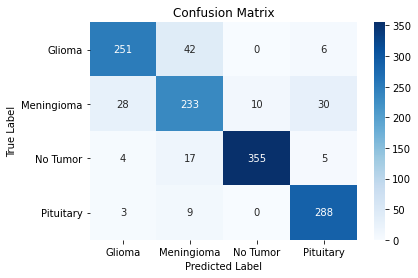

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       299
           1       0.77      0.77      0.77       301
           2       0.97      0.93      0.95       381
           3       0.88      0.96      0.92       300

    accuracy                           0.88      1281
   macro avg       0.87      0.88      0.87      1281
weighted avg       0.88      0.88      0.88      1281



In [33]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
pretrained1_predicted_labels = pre_trained1_model.predict(test_generator, steps=test_steps_per_epoch)
pretrained1_predicted_labels = np.argmax(pretrained1_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pretrained1_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pretrained1_predicted_labels))

#### VGG16

In [34]:
base_model2 = VGG16(input_shape=(224, 244, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
for layer in base_model2.layers:
    layer.trainable = False

pre_trained2_model = Sequential()
pre_trained2_model.add(base_model2)
pre_trained2_model.add(layers.Flatten())
pre_trained2_model.add(layers.Dropout(0.5))
pre_trained2_model.add(layers.Dense(128, activation='relu'))
pre_trained2_model.add(layers.Dropout(0.5))
pre_trained2_model.add(layers.Dense(4, activation='softmax'))

pre_trained2_model.compile(optimizer=Adamax(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

pre_trained2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 32

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Fit the new model with early stopping
pretrained2_history = pre_trained2_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=11,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping])

Epoch 1/11
138/138 [==============================] - 1868s 14s/step - loss: 1.0987 - accuracy: 0.5563 - val_loss: 0.6646 - val_accuracy: 0.7666
Epoch 2/11
138/138 [==============================] - 1923s 14s/step - loss: 0.7638 - accuracy: 0.6878 - val_loss: 0.5228 - val_accuracy: 0.8029
Epoch 3/11
138/138 [==============================] - 2045s 15s/step - loss: 0.6925 - accuracy: 0.7234 - val_loss: 0.4575 - val_accuracy: 0.8338
Epoch 4/11
138/138 [==============================] - 2101s 15s/step - loss: 0.6529 - accuracy: 0.7418 - val_loss: 0.4178 - val_accuracy: 0.8529
Epoch 5/11
138/138 [==============================] - 1968s 14s/step - loss: 0.6119 - accuracy: 0.7682 - val_loss: 0.4394 - val_accuracy: 0.8138
Epoch 6/11
138/138 [==============================] - 1936s 14s/step - loss: 0.5852 - accuracy: 0.7736 - val_loss: 0.3907 - val_accuracy: 0.8529
Epoch 7/11
138/138 [==============================] - 1961s 14s/step - loss: 0.5678 - accuracy: 0.7804 - val_loss: 0.3826 - val_ac

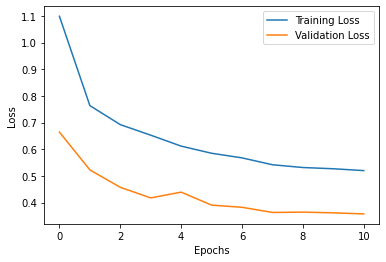

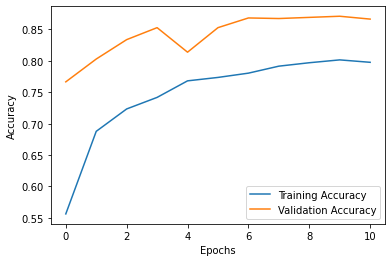

In [36]:
# Plot training history
plt.plot(pretrained2_history.history['loss'], label='Training Loss')
plt.plot(pretrained2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(pretrained2_history.history['accuracy'], label='Training Accuracy')
plt.plot(pretrained2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
pretrained2_test_metrics = pre_trained2_model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Metrics:", pretrained2_test_metrics)

41/41 [==============================] - 363s 9s/step - loss: 0.4424 - accuracy: 0.8283
Test Metrics: [0.4424248933792114, 0.8282591700553894]


41/41 [==============================] - 368s 9s/step


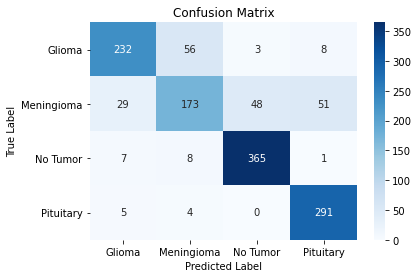

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       299
           1       0.72      0.57      0.64       301
           2       0.88      0.96      0.92       381
           3       0.83      0.97      0.89       300

    accuracy                           0.83      1281
   macro avg       0.82      0.82      0.81      1281
weighted avg       0.82      0.83      0.82      1281



In [38]:
# Get true labels
true_labels = []
for i in range(test_steps_per_epoch):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Get predicted labels
pretrained2_predicted_labels = pre_trained2_model.predict(test_generator, steps=test_steps_per_epoch)
pretrained2_predicted_labels = np.argmax(pretrained2_predicted_labels, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pretrained2_predicted_labels)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma','Meningioma','No Tumor','Pituitary'], yticklabels=['Glioma','Meningioma','No Tumor','Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pretrained2_predicted_labels))